In [ ]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("/content/drive/MyDrive/")
image_path = data_path / "HAM10000"
# image_path = data_path

#If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists.. skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)




/content/drive/MyDrive/HAM10000 directory already exists.. skipping download


In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
    import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")


In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/drive/MyDrive/HAM10000'
There are 7 directories and 0 images in '/content/drive/MyDrive/HAM10000/train'
There are 0 directories and 5372 images in '/content/drive/MyDrive/HAM10000/train/nv'
There are 0 directories and 891 images in '/content/drive/MyDrive/HAM10000/train/mel'
There are 0 directories and 412 images in '/content/drive/MyDrive/HAM10000/train/bcc'
There are 0 directories and 93 images in '/content/drive/MyDrive/HAM10000/train/df'
There are 0 directories and 880 images in '/content/drive/MyDrive/HAM10000/train/bkl'
There are 0 directories and 262 images in '/content/drive/MyDrive/HAM10000/train/akiec'
There are 0 directories and 114 images in '/content/drive/MyDrive/HAM10000/train/vasc'
There are 7 directories and 0 images in '/content/drive/MyDrive/HAM10000/test'
There are 0 directories and 1340 images in '/content/drive/MyDrive/HAM10000/test/nv'
There are 0 directories and 222 images in '/content/drive/MyDrive/HAM10000/test

In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/HAM10000/train'),
 PosixPath('/content/drive/MyDrive/HAM10000/test'))

/content/drive/MyDrive/HAM10000/train/nv/ISIC_0031776.jpg
Random image path: /content/drive/MyDrive/HAM10000/train/nv/ISIC_0031776.jpg
Image class: nv
Image height: 450
Image width: 600


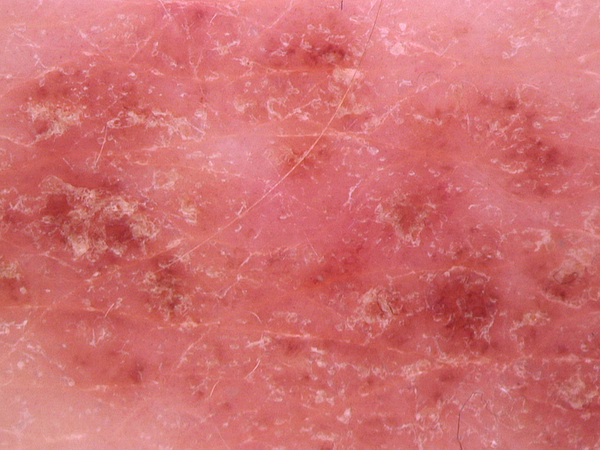

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

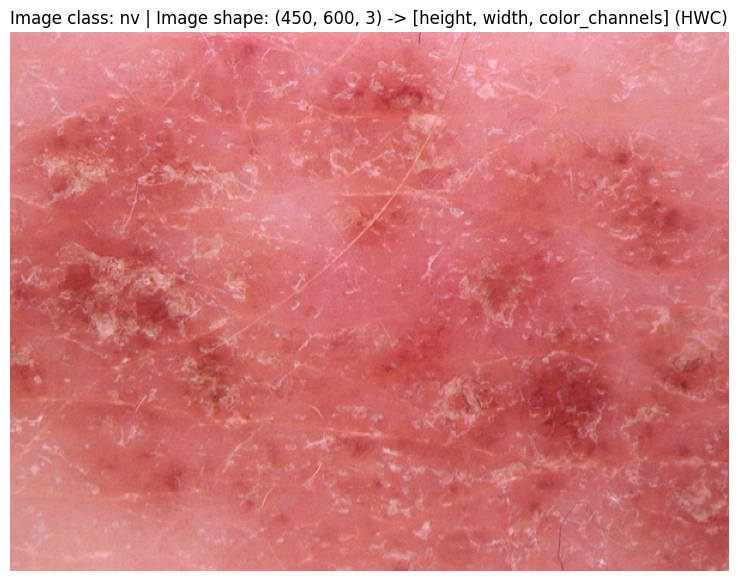

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into torch.Tensor
    transforms.ToTensor()
])

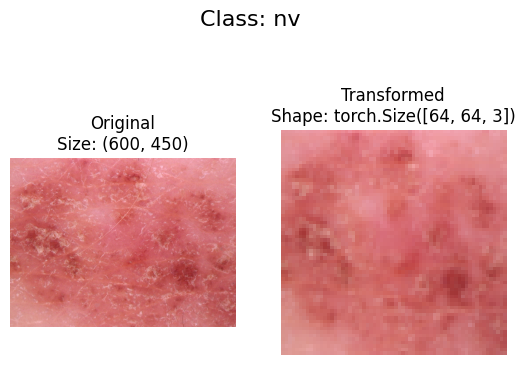

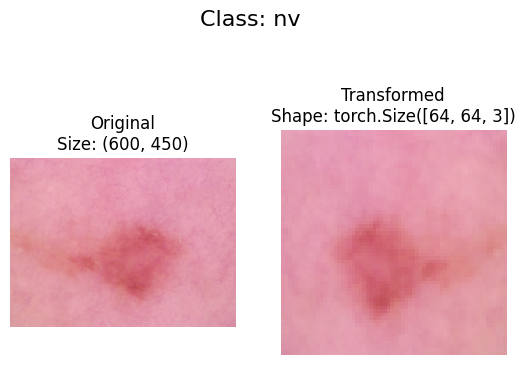

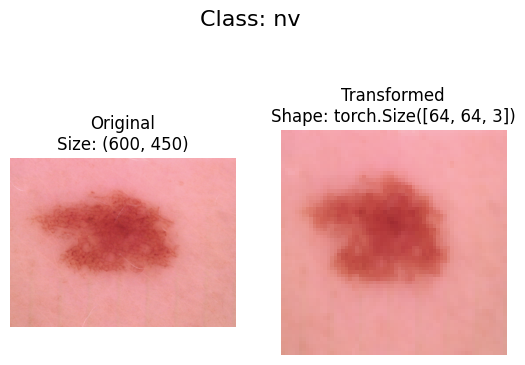

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them then plots the original vs transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # we need to change shape for matplotlib, (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list, transform = data_transform, n=3, seed=42)

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform, # a transform for the data
                                  target_transform=None) # a transform for thr label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 8024
     Root location: /content/drive/MyDrive/HAM10000/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1998
     Root location: /content/drive/MyDrive/HAM10000/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class name as list
class_names = train_data.classes
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx

In [ ]:
len(train_data), len(test_data)

(8024, 1998)

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.7176, 0.6706, 0.6000,  ..., 0.6196, 0.6078, 0.5961],
         [0.6863, 0.6941, 0.5490,  ..., 0.6314, 0.6157, 0.5961],
         [0.6431, 0.6588, 0.6235,  ..., 0.6392, 0.6196, 0.5961],
         ...,
         [0.7529, 0.7725, 0.7804,  ..., 0.6902, 0.6863, 0.6784],
         [0.7569, 0.7569, 0.7765,  ..., 0.6902, 0.6745, 0.6745],
         [0.7451, 0.7490, 0.7569,  ..., 0.6902, 0.6784, 0.6667]],

        [[0.5529, 0.5059, 0.4510,  ..., 0.4000, 0.3882, 0.3804],
         [0.5059, 0.5137, 0.3725,  ..., 0.4275, 0.4000, 0.3804],
         [0.4314, 0.4510, 0.4196,  ..., 0.4314, 0.4039, 0.3725],
         ...,
         [0.6000, 0.6314, 0.6353,  ..., 0.5373, 0.5294, 0.5216],
         [0.6118, 0.6039, 0.6353,  ..., 0.5373, 0.5216, 0.5137],
         [0.5882, 0.5843, 0.6039,  ..., 0.5412, 0.5216, 0.5020]],

        [[0.6235, 0.5608, 0.5098,  ..., 0.4588, 0.4392, 0.4353],
         [0.5529, 0.5569, 0.4235,  ..., 0.4824, 0.4392, 0.4235],
         [0.4784, 0.5020, 0.4667,  ..., 0.4

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'akiec')

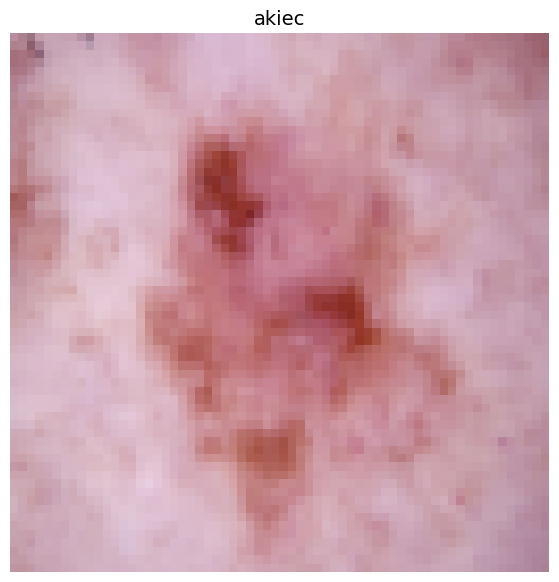

In [ ]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize = (10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x77ff305ca410>,
 <torch.utils.data.dataloader.DataLoader at 0x77ff306d3d60>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(251, 63)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'],
 {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6})

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target dir: /content/drive/MyDrive/HAM10000/train


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# CNN

In [ ]:
# Create a CNN
class FashionMNISTModelV2(nn.Module):
  """Model architecture that replicates tiny VGG
    model from CNN explainer """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 8 * 8, # we need to computer the in features here 7*7 comes from the output of conv_block_3
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.conv_block_3(x)
    # print(f"Output shape of conv_block_3: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x




In [ ]:
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 3,
                              hidden_units = 30,
                              output_shape = len(class_names)).to(device) # output_shape = len(class_names) for multiclass

In [ ]:
# Get a single imahe batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [ ]:
# Create train_steop()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send the data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc



In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss_fn
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # 2. Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }


  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results




In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
# model_0 = TinyVGG(input_shape = 3, # Number of color channels of our target images
#                   hidden_units = 10,
#                   output_shape = len(train_data.classes)).to(device)

model_2 = FashionMNISTModelV2(input_shape = 3,
                              hidden_units = 30,
                              output_shape = len(class_names)).to(device) # output_shape = len(class_names) for multiclass

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model = model_2,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")




  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0697 | Train acc: 0.6670 | Test loss: 0.9821 | Test acc: 0.6647
Epoch: 1 | Train loss: 0.9565 | Train acc: 0.6725 | Test loss: 0.9442 | Test acc: 0.6756
Epoch: 2 | Train loss: 0.9183 | Train acc: 0.6812 | Test loss: 0.9517 | Test acc: 0.6726
Epoch: 3 | Train loss: 0.9017 | Train acc: 0.6855 | Test loss: 0.8955 | Test acc: 0.6875
Epoch: 4 | Train loss: 0.8728 | Train acc: 0.6890 | Test loss: 0.8816 | Test acc: 0.6870
Total training time: 1572.518 seconds


# Unet

In [ ]:
#Unet

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.dropout = nn.Dropout(0.2)
        self.down3 = (Down(256, 512))
        self.dropout = nn.Dropout(0.2)
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, 64))
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(256*256, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x3 = self.dropout(x3)
        x4 = self.down3(x3)
        x4 = self.dropout(x4)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        out = self.max_pool2(x)
        out = out.reshape(out.size(0), -1)
        # print(f"Output shape of out_reshape: {out.shape}")
        out = self.fc1(out)
        # print(f"Output shape of fc1: {out.shape}")
        out = self.relu1(out)
        logits = self.fc2(out)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        self.fc1 = torch.utils.checkpoint(self.fc1)
        self.fc2 = torch.utils.checkpoint(self.fc2)

In [ ]:
torch.manual_seed(42)
n_channels = 3
model_3 = UNet(n_channels,len(class_names), False).to(device)

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Recreate an instance of TinyVGG
# model_0 = TinyVGG(input_shape = 3, # Number of color channels of our target images
#                   hidden_units = 10,
#                   output_shape = len(train_data.classes)).to(device)

model_3 = UNet(n_channels,len(class_names), False).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_3.parameters(), lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_3_results = train(model = model_3,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")




  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9948 | Train acc: 0.6769 | Test loss: 0.9243 | Test acc: 0.6726
Epoch: 1 | Train loss: 0.7955 | Train acc: 0.7109 | Test loss: 0.7859 | Test acc: 0.7110
Epoch: 2 | Train loss: 0.7632 | Train acc: 0.7247 | Test loss: 0.7606 | Test acc: 0.7313
Epoch: 3 | Train loss: 0.7145 | Train acc: 0.7358 | Test loss: 0.8237 | Test acc: 0.7182
Epoch: 4 | Train loss: 0.6797 | Train acc: 0.7488 | Test loss: 0.7897 | Test acc: 0.7056
Epoch: 5 | Train loss: 0.6592 | Train acc: 0.7617 | Test loss: 0.7229 | Test acc: 0.7370
Epoch: 6 | Train loss: 0.6229 | Train acc: 0.7680 | Test loss: 0.7324 | Test acc: 0.7324
Epoch: 7 | Train loss: 0.6052 | Train acc: 0.7762 | Test loss: 0.7873 | Test acc: 0.7365
Epoch: 8 | Train loss: 0.5363 | Train acc: 0.8080 | Test loss: 0.7073 | Test acc: 0.7431
Epoch: 9 | Train loss: 0.4976 | Train acc: 0.8138 | Test loss: 0.7939 | Test acc: 0.7467
Epoch: 10 | Train loss: 0.4366 | Train acc: 0.8411 | Test loss: 0.7816 | Test acc: 0.7480
Epoch: 11 | Train lo